# Параллельные вычисления (1)

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html

## Задачи для совместного разбора

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя пул процессов.

In [5]:
import multiprocessing

files = [f"{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]

In [6]:
%%file count_a.py
def count_a(file):
    with open(file, "r", encoding="utf8") as fp:
        text = fp.read()
    a = text.count("a")
    return a

Overwriting count_a.py


In [7]:
from count_a import count_a

In [8]:
%%time
a = []
for file in files:
    r = count_a(file)
    a.append(r)
sum(a)

Wall time: 233 ms


8998272

In [9]:
%%time
with multiprocessing.Pool(processes=4) as pool:
    r = pool.map(count_a, files)
sum(r)

Wall time: 250 ms


8998272

In [12]:
def dvdv(ab):
    a, b = ab
    print(a*b)

In [13]:
dvdv((1,5))

5


2. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"], используя процессы и очереди.

In [10]:
%%file count_a_2.py
def count_a_2(file):
    with open(file, "r", encoding="utf8") as fp:
        text = fp.read()
    a = text.count("a")
    print(a)
    return a

Writing count_a_2.py


In [11]:
from count_a_2 import count_a_2

In [12]:
%%file count_a_3.py
def count_a_3(file, queue):
    with open(file, "r", encoding="utf8") as fp:
        text = fp.read()
    a = text.count("a")
    print(a)
    queue.put(a)

Writing count_a_3.py


In [13]:
from count_a_3 import count_a_3

In [14]:
%%time
processes = []
queue = multiprocessing.Queue()

for file in files:
    p = multiprocessing.Process(target=count_a_3, args=(file, queue))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()
# тут мы уверены, что все процессы завершились

res = []
while len(res) < 4:
    if not queue.empty():
        res.append(queue.get())
sum(res)

Wall time: 234 ms


8998272

## Лабораторная работа 5

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

<p class="task" id="1"></p>

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок). 

При создании файлов выводите на экран сообщения следующего вида:
`file: <название файла> #rows: <кол-во строк в этом файле>`

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [1]:
import pandas as pd
import multiprocessing
import numpy as np

In [2]:
%%file get_sample.py
import pandas as pd
def get_sample(i, sizes, queue):
    df = pd.read_csv('tag_nsteps.csv', names=['tags', 'n_steps'], skiprows=i*sizes[i-1]+1, nrows=sizes[i])

    name = f'tag_nsteps_{i}.csv'
    print(f'file: {name} \n#rows: {df.shape[0]}')
    #return f'file: {name} \n#rows: {df.shape[0]}'
    df.to_csv(name, index=False)
    queue.put(f'file: {name} \n#rows: {df.shape[0]}\n')

Overwriting get_sample.py


In [3]:
import get_sample

In [4]:
n = 70695585
num_parts = 8
size_one = int(n/num_parts)
size_one

8836948

In [5]:
sizes = [size_one]*7 + [size_one+1]
sum(sizes) == n

True

In [6]:
%%time
processes = []
queue = multiprocessing.Queue()

for i in range(num_parts):
    p = multiprocessing.Process(target=get_sample.get_sample, args=(i, sizes, queue))
    p.start()
    processes.append(p)

for p in processes:
    p.join()
# тут мы уверены, что все процессы завершились

while not queue.empty():
    print(queue.get())

file: tag_nsteps_0.csv 
#rows: 8836948

file: tag_nsteps_1.csv 
#rows: 8836948

file: tag_nsteps_2.csv 
#rows: 8836948

file: tag_nsteps_3.csv 
#rows: 8836948

file: tag_nsteps_4.csv 
#rows: 8836948

file: tag_nsteps_5.csv 
#rows: 8836948

file: tag_nsteps_6.csv 
#rows: 8836948

file: tag_nsteps_7.csv 
#rows: 8836949

Wall time: 23.6 s


<p class="task" id="2"></p>

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [7]:
files = [f'tag_nsteps_{i}.csv' for i in range(8)]

In [8]:
def get_tag_sum_count_from_file(file: str) -> dict:
    df2 = pd.read_csv(file)
    f = df2.groupby('tags').agg({'n_steps': 'sum', 'tags': 'count'}).rename(columns={'n_steps': 'sum', 'tags': 'count'})
    return f.T.to_dict()

In [9]:
%%time
res2 = []
for file in files:
    d = get_tag_sum_count_from_file(file)
    print(f'{file} - "30-minutes-or-less": {d["30-minutes-or-less"]}')
    res2.append(d)

tag_nsteps_0.csv - "30-minutes-or-less": {'sum': 347663, 'count': 45422}
tag_nsteps_1.csv - "30-minutes-or-less": {'sum': 348230, 'count': 45827}
tag_nsteps_2.csv - "30-minutes-or-less": {'sum': 352485, 'count': 46136}
tag_nsteps_3.csv - "30-minutes-or-less": {'sum': 346169, 'count': 45423}
tag_nsteps_4.csv - "30-minutes-or-less": {'sum': 344724, 'count': 45414}
tag_nsteps_5.csv - "30-minutes-or-less": {'sum': 349181, 'count': 45883}
tag_nsteps_6.csv - "30-minutes-or-less": {'sum': 345148, 'count': 45606}
tag_nsteps_7.csv - "30-minutes-or-less": {'sum': 349605, 'count': 46071}
Wall time: 24.2 s


<p class="task" id="3"></p>

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [10]:
res2[0].keys() == res2[1].keys() == res2[1].keys() == res2[3].keys() == res2[4].keys() == res2[5].keys() == res2[6].keys() == res2[7].keys()

True

In [11]:
#def agg_results(tag_sum_count_list: list) -> dict:
#    d_agg = pd.DataFrame(tag_sum_count_list[0]).T
#    for i in tag_sum_count_list[1:]:
#        d_agg += pd.DataFrame(i).T
#    d_agg = d_agg.T.to_dict()
#    return d_agg

In [12]:
#res3 = agg_results(res2)
#res3["30-minutes-or-less"]

In [13]:
def agg_results(tag_sum_count_list: list) -> dict:
    d_agg = tag_sum_count_list[0].copy()
    for i in tag_sum_count_list[1:]:
        for k,v in i.items():
            s_new = v['sum'] + d_agg.get(k,{'sum': 0, 'count': 0})['sum']
            c_new = v['count'] + d_agg.get(k,{'sum': 0, 'count': 0})['count']
            d_agg[k] = {'sum': s_new, 'count': c_new}
    return d_agg

In [30]:
%%time
res3 = agg_results(res2)
res3["30-minutes-or-less"]

Wall time: 2.99 ms


{'sum': 2783205, 'count': 365782}

<p class="task" id="4"></p>

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре. Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла, можно пренебречь.

In [15]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    # tag_sum_count - результат вызова agg_results
    d_mean = {}
    for k, v in tag_sum_count.items():
        d_mean[k] = v['sum']/v['count']
    return d_mean

In [31]:
%%time
res4 = get_tag_mean_n_steps(res3)
res4["30-minutes-or-less"]

Wall time: 0 ns


7.608917333275011

* время расчета статистики для каждого файла = 24.2 s
* время агрегации результатов = 2.99 ms
* время вычисления средного = 0

In [32]:
print(f'общее время = {24.2+2.99/1000+0} s')

общее время = 24.20299 s


<p class="task" id="5"></p>

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [18]:
%%file get_tag_sum_count_from_file2.py
def get_tag_sum_count_from_file2(file: str) -> dict:
    import pandas as pd
    df2 = pd.read_csv(file)
    f = df2.groupby('tags').agg({'n_steps': 'sum', 'tags': 'count'}).rename(columns={'n_steps': 'sum', 'tags': 'count'})
    return f.T.to_dict()

Overwriting get_tag_sum_count_from_file2.py


In [19]:
from get_tag_sum_count_from_file2 import get_tag_sum_count_from_file2

In [20]:
%%time
with multiprocessing.Pool(processes=8) as pool:
    tag_sum_count_list5 = pool.map(get_tag_sum_count_from_file2, files)

Wall time: 6.4 s


In [21]:
for i in tag_sum_count_list5:
    print(f'"30-minutes-or-less": {i["30-minutes-or-less"]}')

"30-minutes-or-less": {'sum': 347663, 'count': 45422}
"30-minutes-or-less": {'sum': 348230, 'count': 45827}
"30-minutes-or-less": {'sum': 352485, 'count': 46136}
"30-minutes-or-less": {'sum': 346169, 'count': 45423}
"30-minutes-or-less": {'sum': 344724, 'count': 45414}
"30-minutes-or-less": {'sum': 349181, 'count': 45883}
"30-minutes-or-less": {'sum': 345148, 'count': 45606}
"30-minutes-or-less": {'sum': 349605, 'count': 46071}


In [28]:
%%time
tag_sum_count5 = agg_results(tag_sum_count_list5)
tag_sum_count5["30-minutes-or-less"]

Wall time: 2.99 ms


{'sum': 2783205, 'count': 365782}

In [29]:
%%time
tag_mean_n_steps5 = get_tag_mean_n_steps(tag_sum_count5)
tag_mean_n_steps5["30-minutes-or-less"]

Wall time: 0 ns


7.608917333275011

* время расчета статистики для каждого файла = 6.4 s
* время агрегации результатов = 2.99 ms
* время вычисления средного = 0

In [33]:
print(f'общее время = {6.4+2.99/1000+0} s')

общее время = 6.40299 s


<p class="task" id="6"></p>

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [25]:
%%file get_tag_sum_count_from_file3.py
def get_tag_sum_count_from_file3(file: str, queue):
    import pandas as pd
    df2 = pd.read_csv(file)
    f = df2.groupby('tags').agg({'n_steps': 'sum', 'tags': 'count'}).rename(columns={'n_steps': 'sum', 'tags': 'count'})
    queue.put(f.T.to_dict())

Overwriting get_tag_sum_count_from_file3.py


In [26]:
from get_tag_sum_count_from_file3 import get_tag_sum_count_from_file3

In [27]:
%%time
#processes = []
queue = multiprocessing.Queue()

for file in files:
    p = multiprocessing.Process(target=get_tag_sum_count_from_file3, args=(file, queue))
    p.start()
#    processes.append(p)
    
#for p in processes:
#    p.join()
# тут мы уверены, что все процессы завершились

tag_sum_count_list6 = []
while len(tag_sum_count_list6) < 8:
    if not queue.empty():
        tag_sum_count_list6.append(queue.get())
        
tag_sum_count6 = agg_results(tag_sum_count_list6)
tag_mean_n_steps6 = get_tag_mean_n_steps(tag_sum_count6)
tag_mean_n_steps6["30-minutes-or-less"]

Wall time: 7.83 s


7.608917333275011

<p class="task" id="7"></p>

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$ (воспользуйтесь функцией `multiprocessing.cpu_count`). Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

In [36]:
K = multiprocessing.cpu_count()
K

12

In [71]:
n = 70695585
num_parts = [int(K/2), K, 2*K]
size_one = [n/num_parts[i] for i in range(3)]
size_one

[11782597.5, 5891298.75, 2945649.375]

In [76]:
sizes = [[round(size_one[i])]*(num_parts[i]-1) + [n-round(size_one[i])*(num_parts[i]-1)] for i in range(3)]
[sum(size) for size in sizes], n

([70695585, 70695585, 70695585], 70695585)

In [79]:
sizes[0]

[11782598, 11782598, 11782598, 11782598, 11782598, 11782595]

In [82]:
files = [[f'tag_nsteps_{i}.csv' for i in range(num_parts[j])] for j in range(3)]
files[0]

['tag_nsteps_0.csv',
 'tag_nsteps_1.csv',
 'tag_nsteps_2.csv',
 'tag_nsteps_3.csv',
 'tag_nsteps_4.csv',
 'tag_nsteps_5.csv']

In [83]:
%%time
processes = []
queue = multiprocessing.Queue()
ex = 0

for i in range(num_parts[ex]):
    p = multiprocessing.Process(target=get_sample.get_sample, args=(i, sizes[ex], queue))
    p.start()
    processes.append(p)

for p in processes:
    p.join()
# тут мы уверены, что все процессы завершились

while not queue.empty():
    print(queue.get())
    
with multiprocessing.Pool(processes=num_parts[ex]) as pool:
    tag_sum_count_list7_1 = pool.map(get_tag_sum_count_from_file2, files[ex])
    
tag_sum_count7_1 = agg_results(tag_sum_count_list7_1)

tag_mean_n_steps7_1 = get_tag_mean_n_steps(tag_sum_count7_1)

tag_mean_n_steps7_1["30-minutes-or-less"]

file: tag_nsteps_0.csv 
#rows: 11782598

file: tag_nsteps_1.csv 
#rows: 11782598

file: tag_nsteps_2.csv 
#rows: 11782598

file: tag_nsteps_3.csv 
#rows: 11782598

file: tag_nsteps_4.csv 
#rows: 11782598

file: tag_nsteps_5.csv 
#rows: 11782595

Wall time: 30.8 s


7.608917333275011

In [84]:
%%time
processes = []
queue = multiprocessing.Queue()
ex = 1

for i in range(num_parts[ex]):
    p = multiprocessing.Process(target=get_sample.get_sample, args=(i, sizes[ex], queue))
    p.start()
    processes.append(p)

for p in processes:
    p.join()
# тут мы уверены, что все процессы завершились

while not queue.empty():
    print(queue.get())
    
with multiprocessing.Pool(processes=num_parts[ex]) as pool:
    tag_sum_count_list7_1 = pool.map(get_tag_sum_count_from_file2, files[ex])
    
tag_sum_count7_1 = agg_results(tag_sum_count_list7_1)

tag_mean_n_steps7_1 = get_tag_mean_n_steps(tag_sum_count7_1)

tag_mean_n_steps7_1["30-minutes-or-less"]

file: tag_nsteps_0.csv 
#rows: 5891299

file: tag_nsteps_1.csv 
#rows: 5891299

file: tag_nsteps_2.csv 
#rows: 5891299

file: tag_nsteps_3.csv 
#rows: 5891299

file: tag_nsteps_4.csv 
#rows: 5891299

file: tag_nsteps_5.csv 
#rows: 5891299

file: tag_nsteps_6.csv 
#rows: 5891299

file: tag_nsteps_7.csv 
#rows: 5891299

file: tag_nsteps_8.csv 
#rows: 5891299

file: tag_nsteps_9.csv 
#rows: 5891299

file: tag_nsteps_10.csv 
#rows: 5891299

file: tag_nsteps_11.csv 
#rows: 5891296

Wall time: 32.8 s


7.608917333275011

In [85]:
%%time
processes = []
queue = multiprocessing.Queue()
ex = 2

for i in range(num_parts[ex]):
    p = multiprocessing.Process(target=get_sample.get_sample, args=(i, sizes[ex], queue))
    p.start()
    processes.append(p)

for p in processes:
    p.join()
# тут мы уверены, что все процессы завершились

while not queue.empty():
    print(queue.get())
    
with multiprocessing.Pool(processes=num_parts[ex]) as pool:
    tag_sum_count_list7_1 = pool.map(get_tag_sum_count_from_file2, files[ex])
    
tag_sum_count7_1 = agg_results(tag_sum_count_list7_1)

tag_mean_n_steps7_1 = get_tag_mean_n_steps(tag_sum_count7_1)

tag_mean_n_steps7_1["30-minutes-or-less"]

file: tag_nsteps_0.csv 
#rows: 2945649

file: tag_nsteps_1.csv 
#rows: 2945649

file: tag_nsteps_2.csv 
#rows: 2945649

file: tag_nsteps_4.csv 
#rows: 2945649

file: tag_nsteps_3.csv 
#rows: 2945649

file: tag_nsteps_8.csv 
#rows: 2945649

file: tag_nsteps_6.csv 
#rows: 2945649

file: tag_nsteps_5.csv 
#rows: 2945649

file: tag_nsteps_7.csv 
#rows: 2945649

file: tag_nsteps_10.csv 
#rows: 2945649

file: tag_nsteps_11.csv 
#rows: 2945649

file: tag_nsteps_9.csv 
#rows: 2945649

file: tag_nsteps_12.csv 
#rows: 2945649

file: tag_nsteps_13.csv 
#rows: 2945649

file: tag_nsteps_15.csv 
#rows: 2945649

file: tag_nsteps_14.csv 
#rows: 2945649

file: tag_nsteps_16.csv 
#rows: 2945649

file: tag_nsteps_17.csv 
#rows: 2945649

file: tag_nsteps_20.csv 
#rows: 2945649

file: tag_nsteps_18.csv 
#rows: 2945649

file: tag_nsteps_19.csv 
#rows: 2945649

file: tag_nsteps_21.csv 
#rows: 2945649

file: tag_nsteps_23.csv 
#rows: 2945658

file: tag_nsteps_22.csv 
#rows: 2945649

Wall time: 41 s


7.608917333275011

In [87]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'время выполнения кода, s')

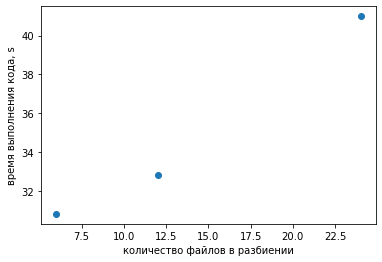

In [95]:
time = [30.8, 32.8, 41]

plt.scatter(num_parts, time)
plt.xlabel('количество файлов в разбиении')
plt.ylabel('время выполнения кода, s')

Text(0, 0.5, 'время выполнения кода, s')

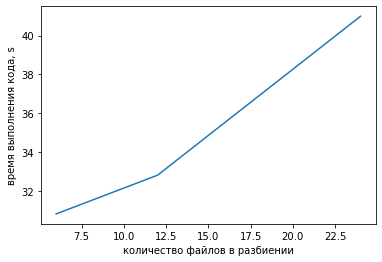

In [96]:
time = [30.8, 32.8, 41]

plt.plot(num_parts, time)
plt.xlabel('количество файлов в разбиении')
plt.ylabel('время выполнения кода, s')

* Разбиение на большее кол-во файлов приводит к увеличению времени выполнения кода